In [6]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os

paths = [
    "results/20241022-180548-MNIST-t=1-e=1000-opt=bgd",
    "results/20241022-223538-MNIST-t=1-e=1000-opt=mesu"
]
n_iterations = 5
n_tasks = 1
n_epochs = 1000
data = []
for path in paths:
    full_accuracies = []
    full_roc_aucs = []
    full_sigma_mean = []
    for it in range(n_iterations):
        current_it_path = os.path.join(path, f"config{it}")
        accuracy_path = os.path.join(current_it_path, "accuracy")
        uncertainty_path = os.path.join(current_it_path, "uncertainty")
        weights_path = os.path.join(current_it_path, "weights")
        
        accuracies = []
        roc_aucs = []
        sigma_mean = []
        for task in range(n_tasks):
            for epoch in range(n_epochs):
                suffix = f"task={task}-epoch={epoch}.npy"
                accuracies.append(jnp.load(os.path.join(accuracy_path, suffix)))
                roc_aucs.append(jnp.load(os.path.join(uncertainty_path, "roc-auc-"+suffix)))
                sigma_mean.append(jnp.load(os.path.join(weights_path, "param-sigma-"+suffix))  )
        accuracies = jnp.array(accuracies)
        roc_aucs = jnp.array(roc_aucs)
        sigma_mean = jnp.array(sigma_mean)
        full_accuracies.append(accuracies)
        full_roc_aucs.append(roc_aucs)
        full_sigma_mean.append(sigma_mean)
    full_accuracies = jnp.array(full_accuracies)
    full_roc_aucs = jnp.array(full_roc_aucs)
    full_sigma_mean = jnp.array(full_sigma_mean)
    data.append((full_accuracies, full_roc_aucs, full_sigma_mean))

/tmp/ipykernel_571823/299516371.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("viridis", 4)


(5, 1000, 1)
(5, 1000)
(5, 1000, 2)
(5, 1000, 1)
(5, 1000)
(5, 1000, 2)


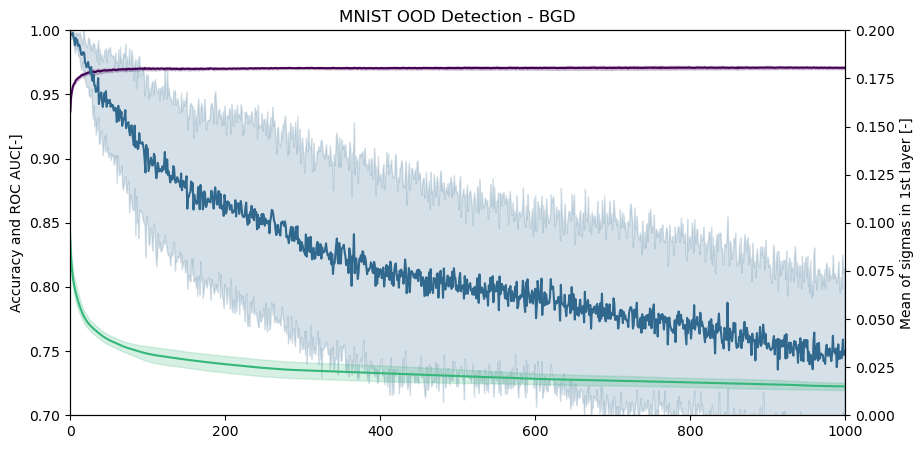

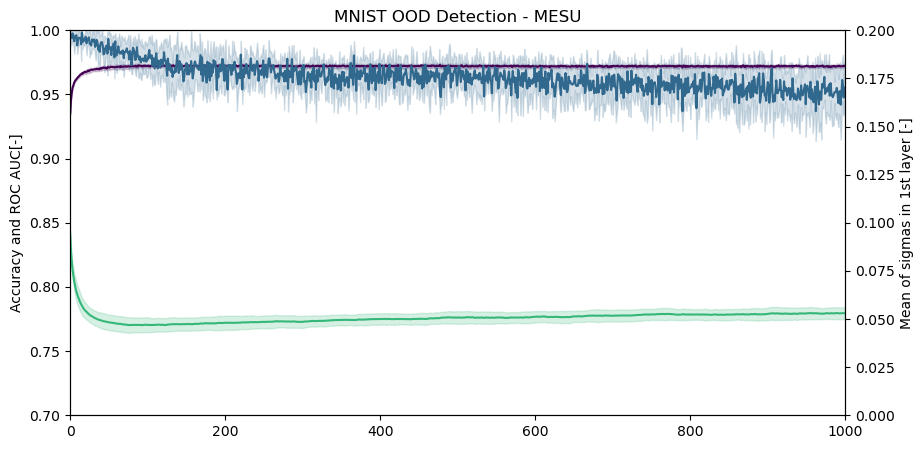

In [36]:
# for each algorithm in data

names = ["BGD", "MESU"]
for alg, name in zip(data, names):
    # make a plot with twinx
    
    fig, ax = plt.subplots(figsize=(10, 5))
    colormap = plt.cm.get_cmap("viridis", 4)
    full_acc = alg[0]
    full_roc = alg[1]
    full_sigma_mean = alg[2]
    # plot accuracy (n_iter, n_epochs, n_tasks)
    # std on n_iter and mean on n_iter
    print(full_acc.shape)
    full_acc_mean = jnp.mean(full_acc, axis=0)
    full_acc_std = jnp.std(full_acc, axis=0)
    ax.plot(jnp.mean(full_acc_mean, axis=1), color=colormap(0))
    ax.fill_between(jnp.arange(n_epochs), jnp.mean(full_acc_mean, axis=1) - jnp.mean(full_acc_std, axis=1), jnp.mean(full_acc_mean, axis=1) + jnp.mean(full_acc_std, axis=1), color=colormap(0), alpha=0.2)
    # plot roc auc (n_iter, n_epochs)
    print(full_roc.shape)
    full_roc_mean = jnp.mean(full_roc, axis=0)
    full_roc_std = jnp.std(full_roc, axis=0)
    ax.plot(full_roc_mean, color=colormap(1))
    ax.fill_between(jnp.arange(n_epochs), full_roc_mean - full_roc_std, full_roc_mean + full_roc_std, color=colormap(1), alpha=0.2)
    print(full_sigma_mean.shape)
    full_sigma_mean_mean = jnp.mean(full_sigma_mean, axis=0)[:, 0]
    full_sigma_mean_std = jnp.std(full_sigma_mean, axis=0)[:, 0]
    
    ax2 = ax.twinx()
    ax2.plot(full_sigma_mean_mean, color=colormap(2))
    ax2.fill_between(jnp.arange(n_epochs), full_sigma_mean_mean - full_sigma_mean_std, full_sigma_mean_mean + full_sigma_mean_std, color=colormap(2), alpha=0.2)
    
    plt.title(f"MNIST OOD Detection - {name}") 
    ax.set_xlim(0, n_epochs)
    ax.set_ylim(0.7, 1) 
    ax2.set_ylim(0, 0.2)
    plt.xlabel("Epochs [-]")
    ax.set_ylabel("Accuracy and ROC AUC[-]")
    ax2.set_ylabel("Mean of sigmas in 1st layer [-]")
    
    